In [1]:
%cd ../src

/home/geb/Workspace/gits/thesis/src


In [2]:
from lib.LRP import *
from lib.H5Dataset import *
from lib.pcapAE import PcapAE
from lib.utils import *
import torch
from lib.pcapAE import PcapAE

In [3]:
!ls ../src/SWAT_A6/eval_byte

eval_pcap.hdf5	log.txt


In [4]:
dummy = H5Dataset("../src/SWAT_A6/eval_byte/eval_pcap.hdf5", train=False, device="cpu",
                  n_frames_input=1, n_frames_output=0, use_cache=False, shape=(100, 32))

In [5]:
compressor = PcapAE(model_path="/home/geb/Workspace/gits/thesis/src/runs/1/best/checkpoint_1_0_0.0007370512957047475.pth.tar",
                            device="cpu", log_dir="../src/runs")

[*] loading model -> /home/geb/Workspace/gits/thesis/src/runs/1/best/checkpoint_1_0_0.0007370512957047475.pth.tar


In [6]:
# define LRP framework
net = compressor.model.encoder
lrp = LRP(compressor.model,'z_rule')

In [7]:
# set plotting inline
%pylab inline
# set fig size
figsize(30,30)

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['time', 'float32']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [8]:
def prinable_ascii(hex_):
    return hex_
    try:
        a = bytes.fromhex(hex_).decode('utf-8')
    except UnicodeDecodeError:
        a = '.'
    return a

In [9]:
# LRP plot wrapper
def plot_LRP(net, lrp, data, fid, pid, loss, height=32,):
    
    # assert shape
    assert data.shape == torch.Size([1, 1, height, height]), exit("provide data with shape (1,1,32,32)")
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
    ax4 = subplot(224, aspect='equal',)
    
    ax1.imshow(data.cpu().reshape((32,32)),cmap='gray', extent=(0, height, height, 0))
    pid.sort()
    if len(pid) > 3:
        pid = f"[{pid[0]},...,{pid[-1]}]"
    ax1.set_title(f"fragment ID: {fid}\n frame ID: {pid}")
    #ax1.set_title(f"fragment ID: {fid}")
    ax1.set_xticks([])
    ax1.set_yticks(arange(0, height+1, height/2))
    
    code = net.get_code(data.unsqueeze(0))
    ax2.imshow(code.cpu().detach().reshape((8,8)),cmap='jet', extent=(0, 8, 8, 0))
    ax2.set_title(f"reconstruction loss: {loss}")
    ax2.set_xticks([])
    
    data_relevance = lrp.relprop(data.unsqueeze(0)).cpu()
    ax3.imshow(data_relevance.reshape((32,32)), cmap='gray', extent=(0, height, height, 0))
    ax3.set_title(f"Relevance heatmap")
    ax3.set_xticks([])
    ax3.set_yticks(arange(0, height+1, height/2))
    
    #  bytes.fromhex('4a4b4c').decode('utf-8')
    arr=(data*255).cpu().detach().numpy().reshape(height*height,)
    y = list(range(0,height+1))
    hex_values = list(map(lambda x: f"{(int(x)):02x}".upper(),arr))
    #
    hex_values = [prinable_ascii(x) for x in hex_values]
    
    #fig, ax = plt.subplots()
    for row in y:
        ax4.scatter([row for x in y], range(height+1), alpha=0)
    #return y    
    data_relevance = data_relevance.reshape(height*height,)
    normalized = (data_relevance-min(data_relevance))/(max(data_relevance)-min(data_relevance))
    #print(hex_values)
    for col, (value, al) in enumerate(zip(hex_values, normalized.tolist())):
        #print(value)
        ax4.text(s=value,
                x=col%height//1,
                y=height-(col/height//1),
                horizontalalignment='center',
                verticalalignment='center',
                fontsize='xx-small',
                 clip_on=False,
                 fontfamily='monospace',
                 fontstretch=1000,
                #fontproperties=prop,
                bbox=dict(facecolor='red',alpha=(al)*0.3,),
                rasterized=False)
    ax4.set_title(f"Original hex representation")
    ax4.set_xticks([])
    ax4.set_yticks(arange(0, 33, 32/2)[::-1])
    plt.rc('axes', unicode_minus=False)
    return fig

In [10]:
figsize(10,10)
plt.rcParams['figure.dpi'] =90
plt.rcParams["figure.autolayout"] = True

In [11]:
idx = 0
FID = idx
PID = dummy[idx][2][:,0].tolist()
loss = "-1"

In [12]:
code = net.get_code(dummy[0][0].unsqueeze(0))

In [13]:
dummy[FID][0].shape

torch.Size([1, 1, 32, 32])

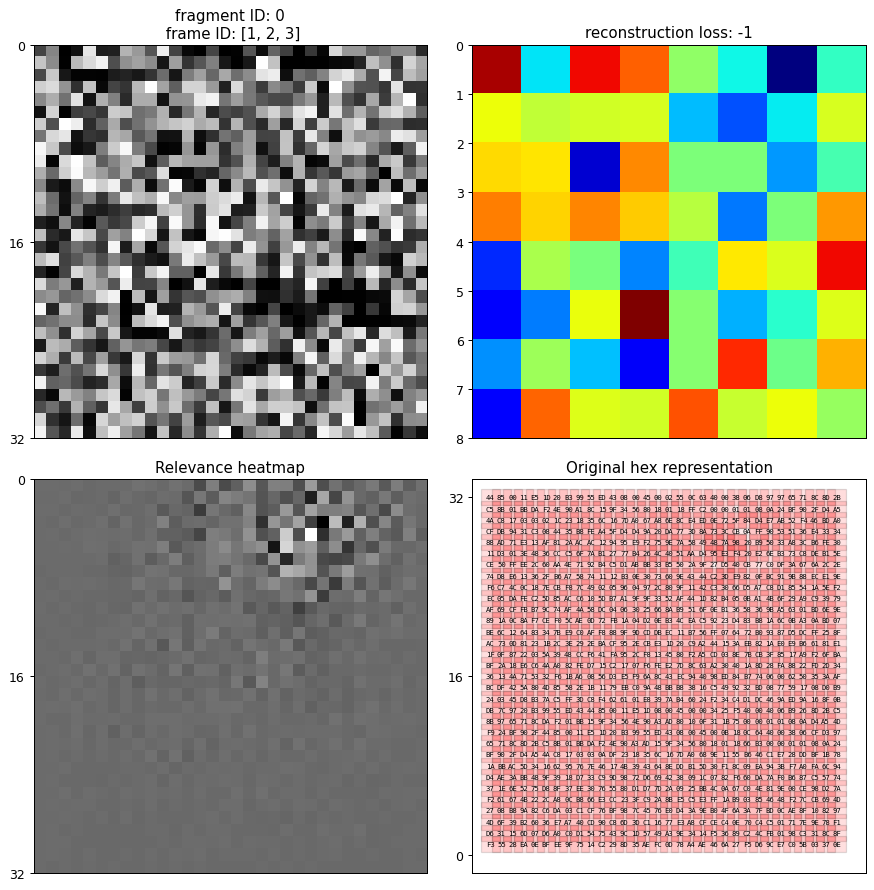

In [14]:
fig = plot_LRP(net, lrp, dummy[FID][0], FID, PID, loss)